In [1]:

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

import re
import os
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import math
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
%matplotlib inline

In [2]:
#pip install --upgrade tensorflow 

In [3]:
data=pd.read_csv("Tweets.csv")


In [4]:
data['airline_sentiment'] = data['airline_sentiment'].replace('neutral', 1)
data['airline_sentiment'] = data['airline_sentiment'].replace('negative', 0)
data['airline_sentiment'] = data['airline_sentiment'].replace('positive', 2)

X = data['text']
y = data['airline_sentiment']

In [5]:
t = Tokenizer()
t.fit_on_texts(X)
vocab_size = len(t.word_index) + 1
sequences = t.texts_to_sequences(X)

In [6]:
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [7]:
tweet_num = max_tweet()
tweet_num

30

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = tweet_num
padded_X = pad_sequences(sequences, padding='post', maxlen=maxlen)

In [9]:
labels = to_categorical(np.asarray(y))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_X, labels, test_size = 0.2, random_state = 0)

In [11]:
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (11712, 30)
y_train size: (11712, 3)
X_test size: (2928, 30)
y_test size: (2928, 3)


In [12]:
embeddings_index = dict()
f = open('glove.6B.100d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [13]:
embedding_matrix = np.zeros((vocab_size, 100))

# fill in matrix
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector

In [14]:
from tensorflow.keras.layers import Embedding

# input is vocab_size, output is 100
# weights from embedding matrix, set trainable = False
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                           input_length = tweet_num, trainable=False)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization

# Model 1: Simple LSTM Model with regularization

In [16]:
lstm_mod1 = Sequential()
lstm_mod1.add(embedding_layer)
lstm_mod1.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod1.add(Dense(3, activation='softmax'))
lstm_mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           1576900   
                                                                 
 lstm (LSTM)                 (None, 256)               365568    
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 1,943,239
Trainable params: 366,339
Non-trainable params: 1,576,900
_________________________________________________________________


In [17]:
hist_1 = lstm_mod1.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 56s 994ms/step - loss: 0.8497 - acc: 0.6246 - val_loss: 0.7592 - val_acc: 0.6795
Epoch 2/100
37/37 [==============================] - 33s 891ms/step - loss: 0.7225 - acc: 0.7048 - val_loss: 0.6785 - val_acc: 0.7384
Epoch 3/100
37/37 [==============================] - 33s 893ms/step - loss: 0.6471 - acc: 0.7371 - val_loss: 0.6254 - val_acc: 0.7512
Epoch 4/100
37/37 [==============================] - 34s 914ms/step - loss: 0.6127 - acc: 0.7481 - val_loss: 0.6089 - val_acc: 0.7533
Epoch 5/100
37/37 [==============================] - 32s 879ms/step - loss: 0.6061 - acc: 0.7516 - val_loss: 0.5651 - val_acc: 0.7772
Epoch 6/100
37/37 [==============================] - 35s 949ms/step - loss: 0.5857 - acc: 0.7619 - val_loss: 0.6256 - val_acc: 0.7576
Epoch 7/100
37/37 [==============================] - 33s 896ms/step - loss: 0.5861 - acc: 0.7643 - val_loss: 0.5753 - val_acc: 0.7700
Epoch 8/100
37/37 [==============================] - 35s 947ms

In [18]:
# Find train and test accuracy
loss, accuracy = lstm_mod1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9544
Testing Accuracy:  0.7879


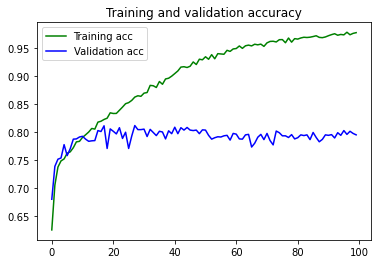

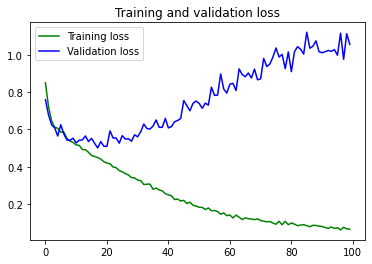

In [19]:
# Plot train/test loss and accuracy
acc = hist_1.history['acc']
val_acc = hist_1.history['val_acc']
loss = hist_1.history['loss']
val_loss = hist_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [21]:
# Get predicted values
y_pred = lstm_mod1.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

In [22]:
# Convert y_test to 1d numpy array
y_test_array = np.zeros(X_test.shape[0])

# Find class with 1
for i in range(0, y_test.shape[0]):
    label_predict = np.argmax(y_test[i])
    y_test_array[i] = label_predict

y_test_array = y_test_array.astype(int)

In [23]:
class_names = np.array(['Negative', 'Neutral', 'Positive'])

Confusion matrix, without normalization
[[1635  164   71]
 [ 202  350   62]
 [  81   41  322]]
Normalized confusion matrix
[[0.87 0.09 0.04]
 [0.33 0.57 0.1 ]
 [0.18 0.09 0.73]]


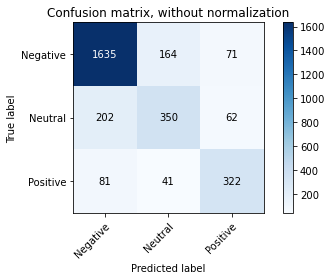

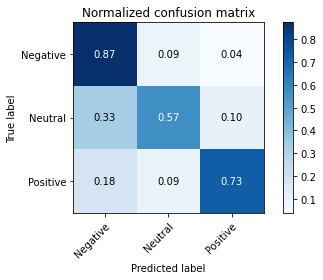

In [24]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Model 2: LSTM with regularization, reduce dimensionality

In [25]:
lstm_mod2 = Sequential()
lstm_mod2.add(embedding_layer)
lstm_mod2.add(LSTM(64, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod2.add(Dense(3, activation='softmax'))
lstm_mod2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           1576900   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,619,335
Trainable params: 42,435
Non-trainable params: 1,576,900
_________________________________________________________________


In [26]:
hist_2 = lstm_mod2.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 10s 169ms/step - loss: 0.8903 - acc: 0.5994 - val_loss: 0.8463 - val_acc: 0.6176
Epoch 2/100
37/37 [==============================] - 6s 169ms/step - loss: 0.8185 - acc: 0.6430 - val_loss: 0.7983 - val_acc: 0.6701
Epoch 3/100
37/37 [==============================] - 5s 137ms/step - loss: 0.7371 - acc: 0.6892 - val_loss: 0.6918 - val_acc: 0.7166
Epoch 4/100
37/37 [==============================] - 5s 143ms/step - loss: 0.6648 - acc: 0.7311 - val_loss: 0.6290 - val_acc: 0.7414
Epoch 5/100
37/37 [==============================] - 6s 164ms/step - loss: 0.6262 - acc: 0.7473 - val_loss: 0.5965 - val_acc: 0.7631
Epoch 6/100
37/37 [==============================] - 6s 151ms/step - loss: 0.6163 - acc: 0.7523 - val_loss: 0.5744 - val_acc: 0.7712
Epoch 7/100
37/37 [==============================] - 5s 146ms/step - loss: 0.5952 - acc: 0.7606 - val_loss: 0.5653 - val_acc: 0.7751
Epoch 8/100
37/37 [==============================] - 5s 137ms/step -

In [27]:
# Find train and test accuracy
loss, accuracy = lstm_mod2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9157
Testing Accuracy:  0.7930


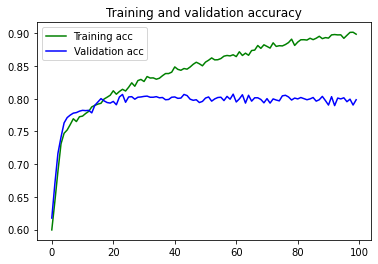

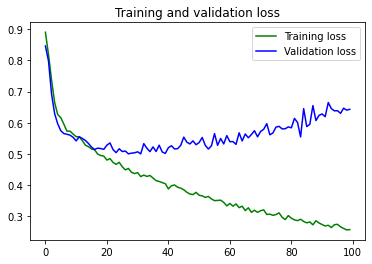

In [28]:
# Plot train/test loss and accuracy
acc = hist_2.history['acc']
val_acc = hist_2.history['val_acc']
loss = hist_2.history['loss']
val_loss = hist_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
# Get predicted values
y_pred = lstm_mod2.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1686  119   65]
 [ 231  327   56]
 [  83   52  309]]
Normalized confusion matrix
[[0.9  0.06 0.03]
 [0.38 0.53 0.09]
 [0.19 0.12 0.7 ]]


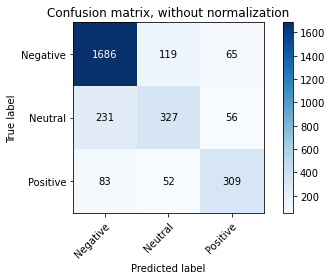

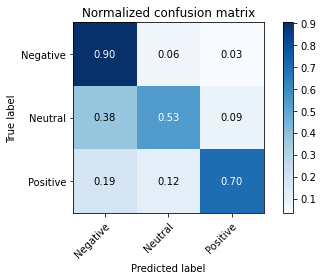

In [30]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [31]:
# LSTM Model
model_3 = Sequential()
model_3.add(embedding_layer)
model_3.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_3.add(LSTM(128,
                dropout = 0.2,
                recurrent_dropout = 0.5))
model_3.add(Dense(3, activation='softmax'))
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [32]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           1576900   
                                                                 
 lstm_2 (LSTM)               (None, 30, 256)           365568    
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,139,975
Trainable params: 563,075
Non-trainable params: 1,576,900
_________________________________________________________________


In [ ]:
history_3 = model_3.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 51s 1s/step - loss: 0.8389 - acc: 0.6382 - val_loss: 0.7707 - val_acc: 0.6773
Epoch 2/100
37/37 [==============================] - 42s 1s/step - loss: 0.6851 - acc: 0.7195 - val_loss: 0.6366 - val_acc: 0.7482
Epoch 3/100
37/37 [==============================] - 43s 1s/step - loss: 0.6406 - acc: 0.7415 - val_loss: 0.5940 - val_acc: 0.7559
Epoch 4/100
37/37 [==============================] - 46s 1s/step - loss: 0.6122 - acc: 0.7480 - val_loss: 0.5803 - val_acc: 0.7636
Epoch 5/100
37/37 [==============================] - 46s 1s/step - loss: 0.5862 - acc: 0.7642 - val_loss: 0.6050 - val_acc: 0.7567
Epoch 6/100
37/37 [==============================] - 48s 1s/step - loss: 0.5760 - acc: 0.7626 - val_loss: 0.5545 - val_acc: 0.7755
Epoch 7/100
37/37 [==============================] - 48s 1s/step - loss: 0.5560 - acc: 0.7728 - val_loss: 0.5662 - val_acc: 0.7768
Epoch 8/100
37/37 [==============================] - 48s 1s/step - loss: 0.5388 - a

In [ ]:
# Find train and test accuracy
loss, accuracy = model_3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
# Plot train/test loss and accuracy
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# GRU Model 2: reduce number of epochs
model_4 = Sequential()
model_4.add(embedding_layer)
model_4.add(GRU(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_4.add(GRU(128,
                dropout = 0.2,
                recurrent_dropout = 0.5))
model_4.add(Dense(3, activation='softmax'))
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
model_4.summary()

In [ ]:
history_4 = model_4.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

In [ ]:
loss, accuracy = model_4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))